# Importing OSM data from osmnx

See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer
# !pip install osmnx

## Setup

If you're prepared to get your hands dirty, it is possible to directly query the [OSM API](https://wiki.openstreetmap.org/wiki/API) and to then use this data to create a `cityseer` graph. This can be preferred in situations where you want detailed control over the structure of the OSM API query. However, if you prefer, `OSM` data can also be retrieved with [`OSMnx`](https://osmnx.readthedocs.io) and then converted into a `cityseer` compatible `networkX` graph.

The following example makes use of data for London Soho.


In [2]:
import osmnx as ox
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# centrepoint
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buffer_dist = 1250
buffer_poly = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buffer_poly.bounds


# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=buffer_dist, simplify=False)

/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are e

## Workflow 1

One option is to both download and simplify the data in `OSMnx` and to then convert the graph from `OSMnx` to `cityseer` (per the `io.nx_from_osm_nx` method).


INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 5388/5388 [00:00<00:00, 5673.20it/s]


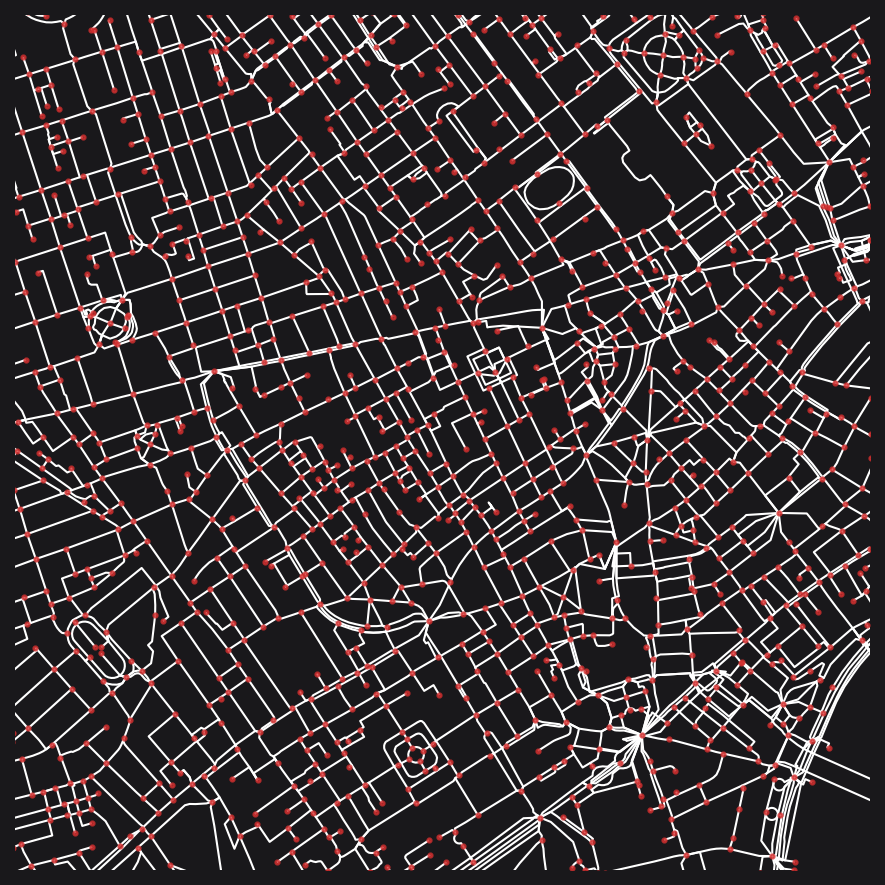

In [3]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(multi_di_graph_simpl, tolerance=10, dead_ends=True)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = io.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Another option is to immediately convert the `osmnx` graph to `cityseer` before downstream processing. This is preferable because it is then easier for `cityseer` to retain the integrity of the roadway geometries while enforcing node coordinate validation for intersections.


In [4]:
# WORKFLOW 2: Using cityseer to manually clean an OSMnx graph
# ===========================================================
G_raw = io.nx_from_osm_nx(multi_di_graph_raw)

INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 27510/27510 [00:04<00:00, 5554.82it/s]


INFO:cityseer.tools.graphs:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 14387/14387 [00:00<00:00, 154885.66it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 16418/16418 [00:02<00:00, 7484.85it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 16418/16418 [00:00<00:00, 22148.02it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14387/14387 [00:01<00:00, 7658.23it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 4764/4764 [00:00<00:00, 276398.33it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 4243/4243 [00:00<00:00, 41956.29it/s]
INFO:cityseer.tools.graphs:Creating nodes STR tree
100%|██████████| 3957/3957 [00:00<00:00, 96043.87it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 3957/3957 [00:00<00:00, 6062.45it/s]
INFO:ci

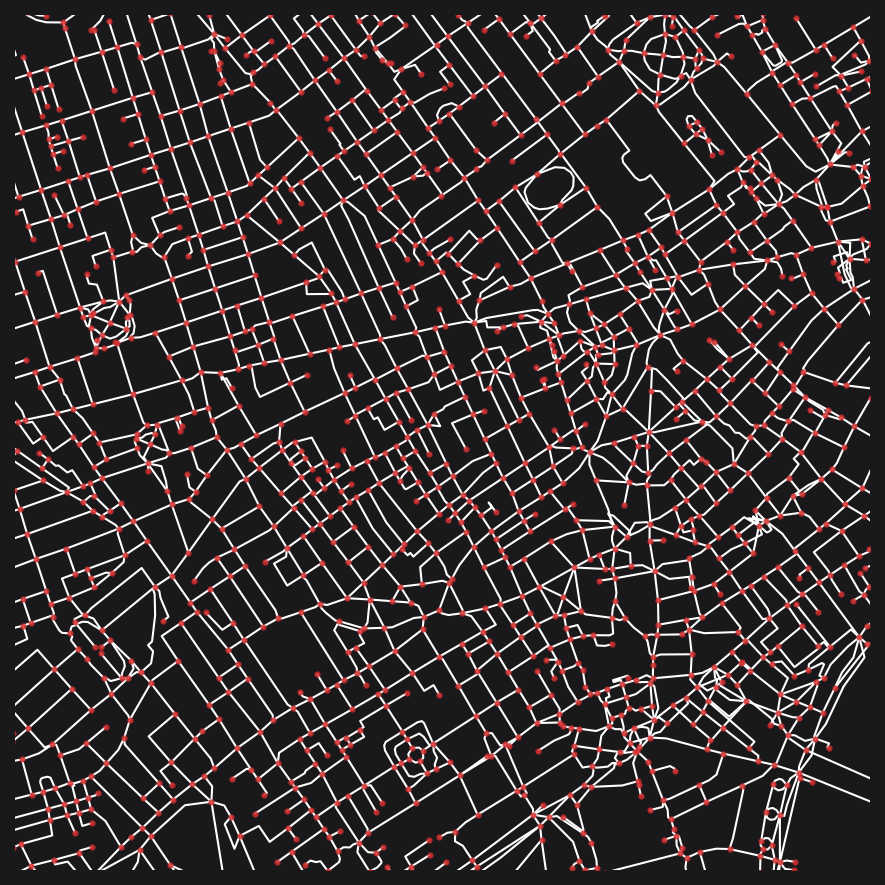

In [5]:
G = graphs.nx_wgs_to_utm(G_raw)
G = graphs.nx_simple_geoms(G)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G, despine=20, remove_disconnected=True)
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=15, crawl=True, min_node_group=4, cent_min_degree=4, cent_min_names=4)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(
    G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4, cent_min_names=4
)
G4 = graphs.nx_iron_edges(G3)
simple_plot(G4)

## Workflow 3

A further option is to simply download the OSM graph directly from within `cityseer`. The following uses a default OSM query, however, the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) can be used to roll-your-own. See documentation for more information.


INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 11904/11904 [00:00<00:00, 126260.60it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 13517/13517 [00:00<00:00, 630337.07it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 13517/13517 [00:00<00:00, 35124.77it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 11904/11904 [00:01<00:00, 6347.82it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 3824/3824 [00:00<00:00, 263869.09it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 3397/3397 [00:00<00:00, 45219.13it/s]
INFO:cityseer.tools.graphs:Creating nodes STR tree
100%|██████████| 3129/3129 [00:00<00:00, 78405.47it/s]
INFO:cityseer.tools.gra

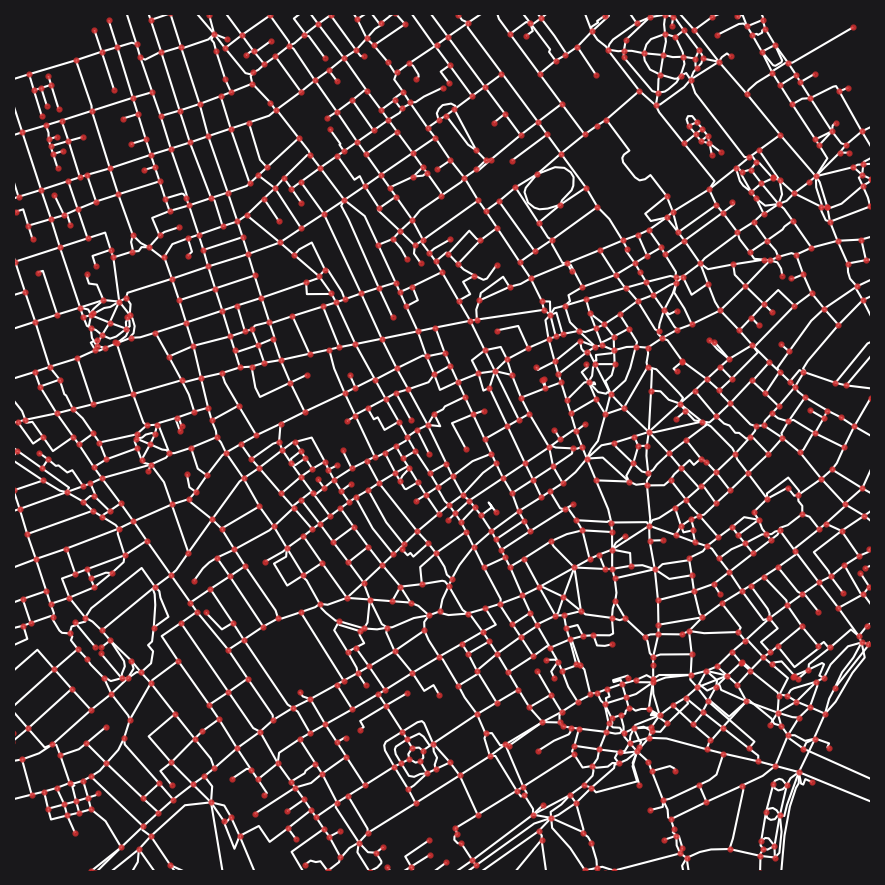

In [6]:
# WORKFLOW 3: Using cityseer to download and automatically simplify the graph
# ===========================================================================
poly_wgs, _poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer_dist)
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True, remove_parallel=True, iron_edges=True)
simple_plot(G_utm)